# Segmentation of Indian Traffic

In [ ]:
!pip install segmentation_models
!pip install q tensorflow==2.1

In [ ]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from tqdm.notebook import tqdm
import cv2
import urllib.request
import tensorflow as tf
from sklearn.model_selection import train_test_split
import segmentation_models as sm
from segmentation_models import Unet
from segmentation_models.metrics import iou_score
tf.keras.backend.set_image_data_format('channels_last')
import imgaug.augmenters as iaa
import warnings
warnings.filterwarnings("ignore")
# import albumentations as A
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Segmentation Models: using `tf.keras` framework.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [ ]:
!wget --header="Host: doc-10-54-docs.googleusercontent.com" --header="User-Agent: Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/87.0.4280.141 Safari/537.36" --header="Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9" --header="Accept-Language: en-US,en;q=0.9,hi;q=0.8" --header="Cookie: AUTH_rfhnsphdti3pb2hbbsh7ssj4umaao2ju_nonce=vg7uev2fk6ggm" --header="Connection: keep-alive" "https://doc-10-54-docs.googleusercontent.com/docs/securesc/2gk73j8m11uhf6m10idod21ut50aitru/i6qd1ckl8bb6jl2m2akm2q77s1qe6sk0/1611120150000/00484516897554883881/14152685769056492470/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=vg7uev2fk6ggm&user=14152685769056492470&hash=h4dauc2s7kqti6qdhrdo97hkm2ngkrvl" -c -O 'data.zip'

--2021-01-20 05:25:39--  https://doc-10-54-docs.googleusercontent.com/docs/securesc/2gk73j8m11uhf6m10idod21ut50aitru/i6qd1ckl8bb6jl2m2akm2q77s1qe6sk0/1611120150000/00484516897554883881/14152685769056492470/1iQ93IWVdR6dZ6W7RahbLq166u-6ADelJ?e=download&authuser=0&nonce=vg7uev2fk6ggm&user=14152685769056492470&hash=h4dauc2s7kqti6qdhrdo97hkm2ngkrvl
Resolving doc-10-54-docs.googleusercontent.com (doc-10-54-docs.googleusercontent.com)... 64.233.184.132, 2a00:1450:400c:c0b::84
Connecting to doc-10-54-docs.googleusercontent.com (doc-10-54-docs.googleusercontent.com)|64.233.184.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-zip-compressed]
Saving to: ‘data.zip’

data.zip                [          <=>       ]   2.18G  34.3MB/s    in 41s     

2021-01-20 05:26:21 (54.8 MB/s) - ‘data.zip’ saved [2339740971]



In [ ]:
!unzip /content/data.zip

In [ ]:
def return_file_names_df(root_dir):
  '''
  This Function take input as dir and return dataframe contain two columns
  1st column contain path of the image files
  2nd column contain path of the json files 
   '''
 
  # store image path in list
  image_path = [ ]
  for root,dir, files in sorted(os.walk( root_dir + '/images')):
      for i in sorted(files):
        image_path.append(str(root)+ "/" + str(i))

################################################################################     
  
  # store json path in list
  json_path = [ ]
  for root,dir, files in sorted(os.walk(root_dir + '/mask')):
    for i in sorted(files):
      json_path.append(str(root)+ "/" + str(i))

################################################################################
   
  #create dataframe  
  data = pd.DataFrame(columns= ['image', 'json'])
  data['image'] = image_path
  data['json']  = json_path


  return data

In [ ]:
data_df = return_file_names_df('/content/data')
print(data_df.shape)
data_df.head()

(4008, 2)


image                                               json
0  /content/data/images/201/frame0029_leftImg8bit...  /content/data/mask/201/frame0029_gtFine_polygo...
1  /content/data/images/201/frame0299_leftImg8bit...  /content/data/mask/201/frame0299_gtFine_polygo...
2  /content/data/images/201/frame0779_leftImg8bit...  /content/data/mask/201/frame0779_gtFine_polygo...
3  /content/data/images/201/frame1019_leftImg8bit...  /content/data/mask/201/frame1019_gtFine_polygo...
4  /content/data/images/201/frame1469_leftImg8bit...  /content/data/mask/201/frame1469_gtFine_polygo...

> If you observe the dataframe, we can consider each row as single data point, where first feature is image and the second feature is corresponding json file

In [ ]:
def grader_1(data_df):
    for i in data_df.values:
        if not (path.isfile(i[0]) and path.isfile(i[1]) and i[0][12:i[0].find('_')]==i[1][10:i[1].find('_')]):
            return False
    return True

In [ ]:
grader_1(data_df)

True

## 2. Structure of sample Json file
https://i.imgur.com/EfR5KmI.png

#### Compute the unique labels

Let's see how many unique objects are there in the json file.
to see how to get the object from the json file please check <a href='https://www.geeksforgeeks.org/read-json-file-using-python/'>this blog </a>

In [ ]:
def return_unique_labels(data_df):
    '''
    This function take input as dataframe and return unique labels of set
    This function open json file one by one and append label values in list
    using set get unique values

    '''

    unique_labels = [ ]
    for file in tqdm(data_df.json):
      with open( file ) as g :
        data = json.load(g)
        for dict in data['objects']:
          unique_labels.append(dict['label'])
    
    return set(unique_labels)

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
print(unique_labels)

{'train', 'bus', 'non-drivable fallback', 'rail track', 'traffic sign', 'fence', 'ground', 'guard rail', 'ego vehicle', 'fallback background', 'tunnel', 'unlabeled', 'building', 'out of roi', 'drivable fallback', 'caravan', 'traffic light', 'pole', 'parking', 'bicycle', 'billboard', 'truck', 'autorickshaw', 'polegroup', 'rectification border', 'wall', 'bridge', 'curb', 'animal', 'sky', 'vegetation', 'rider', 'motorcycle', 'sidewalk', 'obs-str-bar-fallback', 'person', 'car', 'trailer', 'road', 'vehicle fallback'}


<img src='https://i.imgur.com/L4QH6Tp.png'>

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [ ]:
def grader_2(unique_labels):
    if (not (set(label_clr.keys())-set(unique_labels))) and len(unique_labels) == 40:
        print("True")
    else:
        print("Flase")

grader_2(unique_labels)

True


## 3. Extracting the polygons from the json files

In [ ]:
def get_poly(file):
    
    '''
    This function take input as json file
    Return height, width, unique label and cordinate objects of corrospoding json file 
    '''
    
    a = open(file,'r')
    f = json.loads(a.read())

    height = f['imgHeight']
    width  = f['imgWidth']

    label_list = []
    polygon_list = []

    for i in f['objects']:

        vertex = [tuple(l) for l in i['polygon']]

        label_list.append(i['label'])
        polygon_list.append(vertex)

    
    # * note that label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
    # the other represents the location
    
    # width of the image
    # height of the image

    return width , height , label_list , polygon_list
    

In [ ]:

def grader_3(file):
    w, h, labels, vertexlist = get_poly(file)
    print(len((set(labels)))==18 and len(vertexlist)==227 and w==1920 and h==1080 \
          and isinstance(vertexlist,list) and isinstance(vertexlist[0],list) and isinstance(vertexlist[0][0],tuple) )

# i changed it 
grader_3('/content/data/mask/201/frame0029_gtFine_polygons.json')

True


## 4. Creating Image segmentations by drawing set of polygons

### Example

(28, 28, 3)
[[0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0]
 [0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 2 2 2 2 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 2 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 0 0]
 [0 0 0 0 0 0 0 0 0 0 3 3 3 3 3 3 3 3 3 3 3 

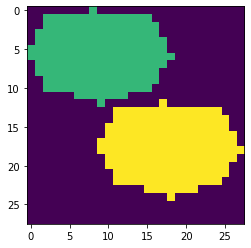

In [ ]:
import math 
from PIL import Image, ImageDraw 
from PIL import ImagePath  
side=8
x1 = [ ((math.cos(th) + 1) *9, (math.sin(th) + 1) * 6) for th in [i * (2 * math.pi) / side for i in range(side)] ]
x2 = [ ((math.cos(th) + 2) *9, (math.sin(th) + 3) *6) for th in [i * (2 * math.pi) / side for i in range(side)] ]

img = Image.new("RGB", (28,28))
img1 = ImageDraw.Draw(img)
# please play with the fill value
# writing the first polygon
img1.polygon(x1, fill =20)
# writing the second polygon
img1.polygon(x2, fill =30)

img=np.array(img)
# note that the filling of the values happens at the channel 1, so we are considering only the first channel here
plt.imshow(img[:,:,0])
print(img.shape)
print(img[:,:,0]//10)
im = Image.fromarray(img[:,:,0])
im.save("test_image.png")

In [ ]:
data_df

image                                               json
0     /content/data/images/201/frame0029_leftImg8bit...  /content/data/mask/201/frame0029_gtFine_polygo...
1     /content/data/images/201/frame0299_leftImg8bit...  /content/data/mask/201/frame0299_gtFine_polygo...
2     /content/data/images/201/frame0779_leftImg8bit...  /content/data/mask/201/frame0779_gtFine_polygo...
3     /content/data/images/201/frame1019_leftImg8bit...  /content/data/mask/201/frame1019_gtFine_polygo...
4     /content/data/images/201/frame1469_leftImg8bit...  /content/data/mask/201/frame1469_gtFine_polygo...
...                                                 ...                                                ...
4003  /content/data/images/429/frame13262_leftImg8bi...  /content/data/mask/429/frame13262_gtFine_polyg...
4004  /content/data/images/429/frame13699_leftImg8bi...  /content/data/mask/429/frame13699_gtFine_polyg...
4005  /content/data/images/429/frame15812_leftImg8bi...  /content/data/mask/429/frame15812_gtFine_polyg...
4006  /content/data/images/429/frame18062_leftImg8bi...  /content/data/mask/429/frame18062_gtFine_polyg...
4007  /content/data/images/429/frame18403_leftImg8bi...  /content/data/mask/429/frame18403_gtFine_polyg...

[4008 rows x 2 columns]

In [ ]:
def compute_masks(data_df):
    ''' 
    This function take input as dataframe
    Return image of the mask and it path with dataframe
    '''


    mask_path = [ ]
    rows =  [ ]
    for path in tqdm(data_df['json'].values):
        
        new_path = path.replace('mask','output')
        new_path = new_path.replace('json','png')

        w, h, label, cordinate = get_poly(path)
        img  = Image.new('RGB', (w,h))
        img1 = ImageDraw.Draw(img)

        for l, c in zip(label, cordinate):
            try :
                img1.polygon(c, fill= label_clr[l])
            except :
                pass

        os.makedirs(os.path.dirname(new_path), exist_ok = True)
        
        image = np.array(img)
        mask_path.append(new_path)
        cv2.imwrite(new_path, image)

    data_df['mask'] = mask_path

    return data_df
    

In [ ]:
dataframe = compute_masks(data_df)

In [ ]:
data_df.head()

image  ...                                               mask
0  /content/data/images/201/frame0029_leftImg8bit...  ...  /content/data/output/201/frame0029_gtFine_poly...
1  /content/data/images/201/frame0299_leftImg8bit...  ...  /content/data/output/201/frame0299_gtFine_poly...
2  /content/data/images/201/frame0779_leftImg8bit...  ...  /content/data/output/201/frame0779_gtFine_poly...
3  /content/data/images/201/frame1019_leftImg8bit...  ...  /content/data/output/201/frame1019_gtFine_poly...
4  /content/data/images/201/frame1469_leftImg8bit...  ...  /content/data/output/201/frame1469_gtFine_poly...

[5 rows x 3 columns]

True
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


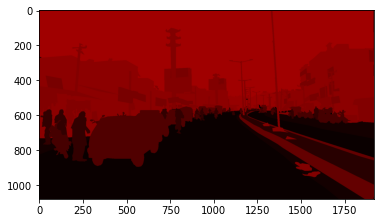

In [ ]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('/content/data/output/201/frame0029_gtFine_polygons.png')
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

# Task 2: Applying Unet to segment the images

In [ ]:
x_train, x_test = train_test_split(data_df, test_size = 0.15, random_state = 42)

print(x_train.shape)
print(x_test.shape)

(3406, 3)
(602, 3)


In [ ]:
#!pip install -U segmentation-models
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
# we are importing the pretrained unet from the segmentation models
# https://github.com/qubvel/segmentation_models

import segmentation_models as sm
from segmentation_models import Unet
# sm.set_framework('tf.keras')
tf.keras.backend.set_image_data_format('channels_last')

In [ ]:
image_size = 128
model = Unet('resnet34', 
             encoder_weights='imagenet', 
             classes=21, 
             activation='softmax',
             encoder_freeze= True,
             input_shape=(image_size, image_size,3))

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 128, 128, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_34 (ZeroPadding2 (None, 134, 134, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 64, 64, 64)   9408        zero_padding2d_34[0][0]          
____________________________________________________________________________________________

In [ ]:
def visualize(**images):
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        if i==1:
            plt.imshow(image, cmap='gray', vmax=1, vmin=0)
        else:
            plt.imshow(image)
    plt.show()

###############################################################################################
CLASSES = list(set(label_clr.values()))

class Dataset:
    def __init__(self, data_df ):
        
        # the paths of images
        self.images_fps   = data_df['image'].values
        # the paths of segmentation images
        self.masks_fps    = data_df['mask'].values
        

        # giving labels for each class
        self.class_values = CLASSES
    
    def __getitem__(self, i):
        
        image = cv2.imread(self.images_fps[i], cv2.IMREAD_UNCHANGED)
        image = cv2.resize(image, (img_size, img_size), interpolation=cv2.INTER_AREA)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(self.masks_fps[i], cv2.IMREAD_UNCHANGED)
        image_mask = cv2.resize(mask, (img_size , img_size), interpolation=cv2.INTER_NEAREST)
        #image_mask = mask//10

        image_masks = [(image_mask[:, :, 0] == v) for v in self.class_values]
        image_mask = np.stack(image_masks, axis=-1).astype('float')
        
        return image, image_mask
        
    def __len__(self):
        return len(self.images_fps)
    
    
class Dataloder(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

In [ ]:
# Dataset for train images
img_size = 128
train_dataset = Dataset(x_train)
test_dataset  = Dataset(x_test)

train_dataloader = Dataloder(train_dataset, batch_size=4)
test_dataloader  = Dataloder(test_dataset, batch_size=4)

In [ ]:
print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(4, 128, 128, 3)
(4, 128, 128, 21)


In [ ]:
optim = tf.keras.optimizers.Adam(lr = 0.001)
loss = sm.losses.cce_dice_loss
model.compile(optim, loss, metrics=[iou_score])

In [ ]:
history = model.fit_generator(train_dataloader, 
                              steps_per_epoch=len(train_dataloader), 
                              epochs= 8,
                              validation_data=test_dataloader)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 851 steps, validate for 150 steps
Epoch 1/8
851/851 [==============================] - 271s 319ms/step - loss: 0.8003 - iou_score: 0.1885 - val_loss: 0.7280 - val_iou_score: 0.2422
Epoch 2/8
851/851 [==============================] - 261s 307ms/step - loss: 0.7095 - iou_score: 0.2563 - val_loss: 0.7044 - val_iou_score: 0.2590
Epoch 3/8
851/851 [==============================] - 258s 303ms/step - loss: 0.6766 - iou_score: 0.2825 - val_loss: 0.6749 - val_iou_score: 0.2864
Epoch 4/8
851/851 [==============================] - 257s 302ms/step - loss: 0.6328 - iou_score: 0.3227 - val_loss: 0.5278 - val_iou_score: 0.4302
Epoch 5/8
851/851 [==============================] - 259s 304ms/step - loss: 0.4969 - iou_score: 0.4562 - val_loss: 0.5173 - val_iou_score: 0.4420
Epoch 6/8
851/851 [==============================] - 258s 303ms/step - loss: 0.4567 - iou_score: 0.4934 - val_loss: 0.4709 - val_iou_score: 0.4894
Epoch 7/8
851/851 [=====

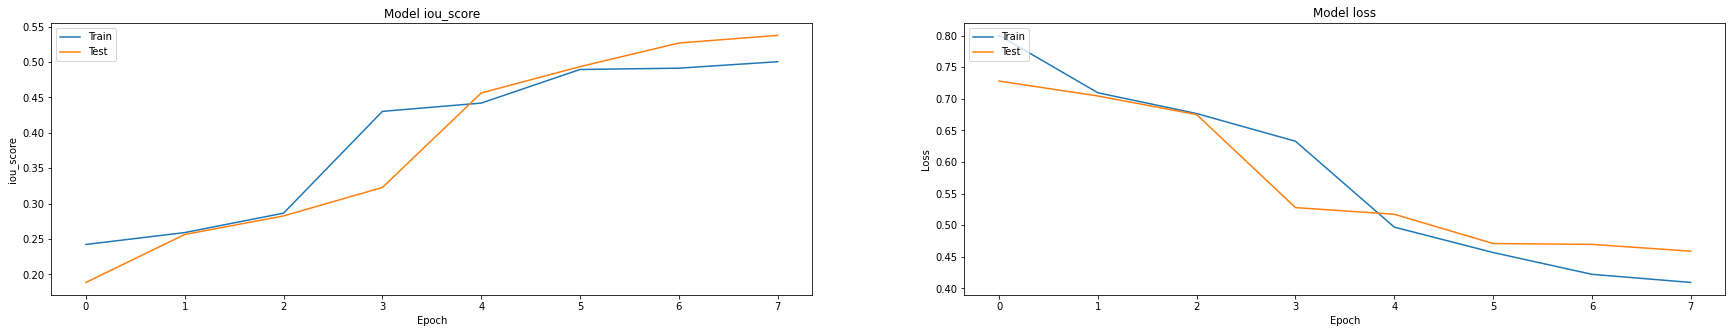

In [ ]:
# Plot training & validation iou_score values

plt.figure(figsize=(30, 5))
plt.subplot(121)

plt.plot(history.history['val_iou_score'])
plt.plot(history.history['iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

plt.show()

(4, 128, 128, 3)
1


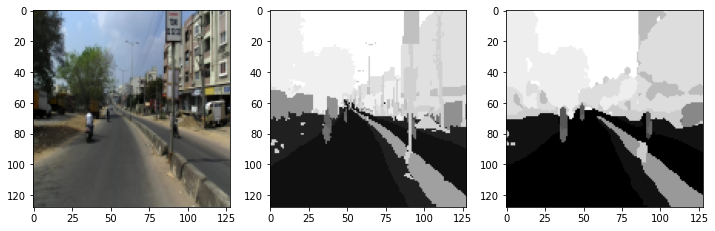

2


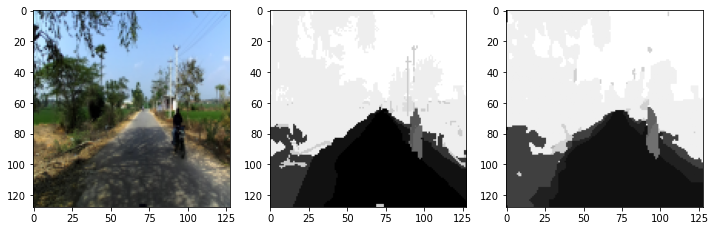

3


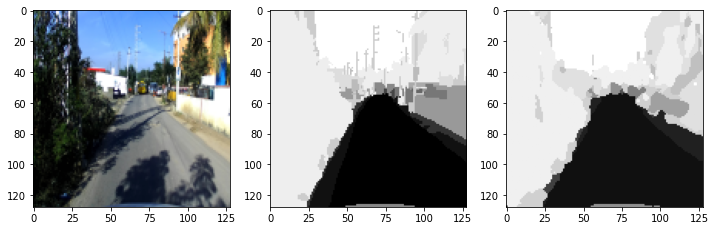

4


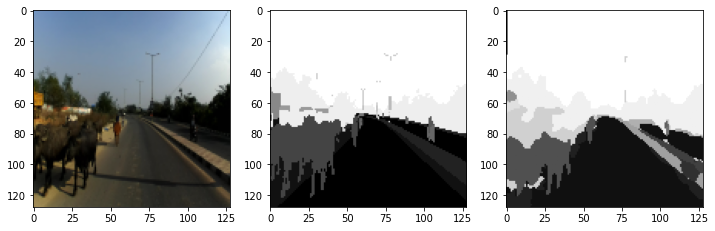

(4, 128, 128, 3)
1


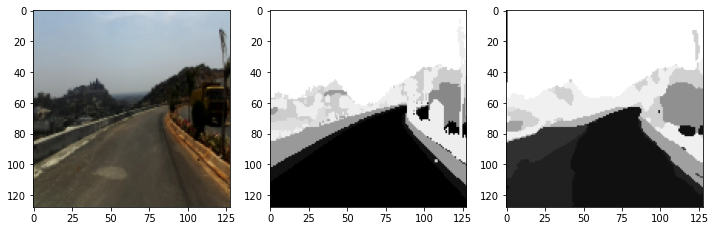

2


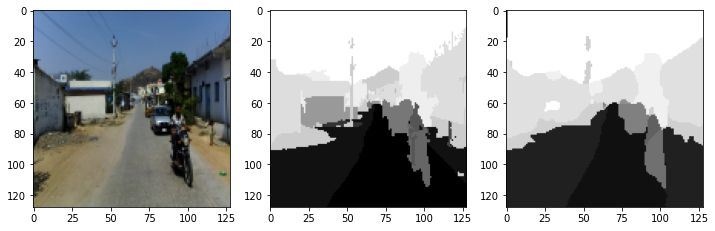

3


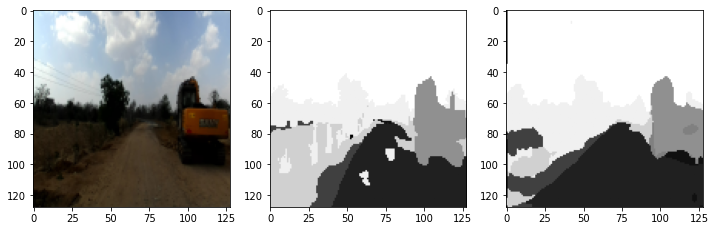

4


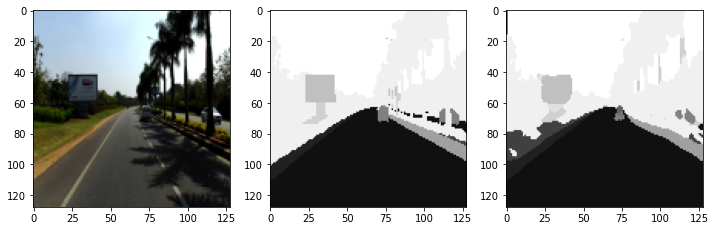

(4, 128, 128, 3)
1


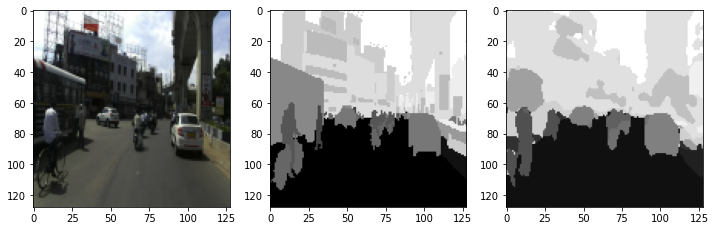

2


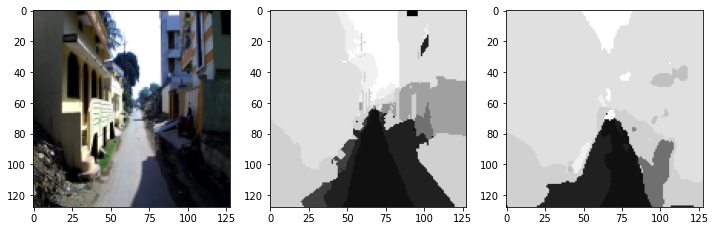

3


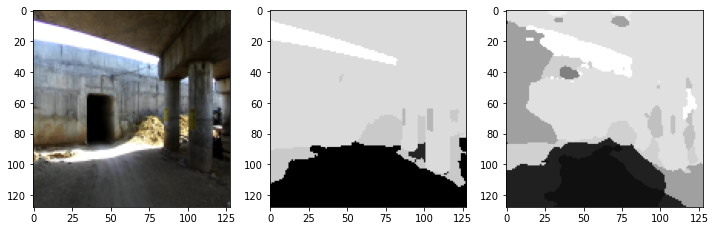

4


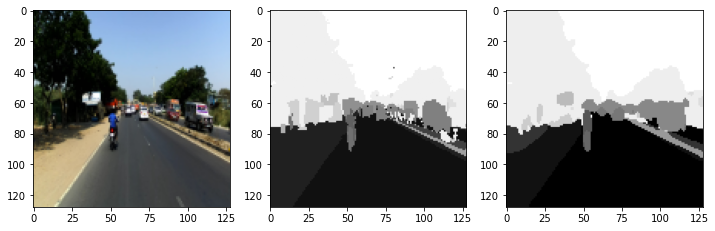

(4, 128, 128, 3)
1


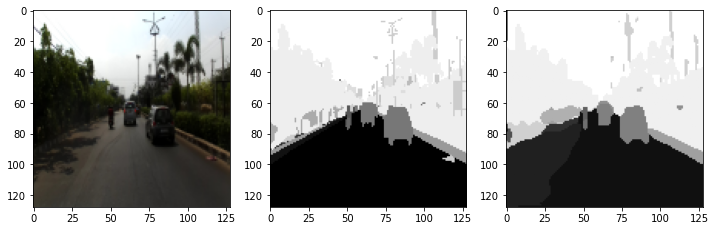

2


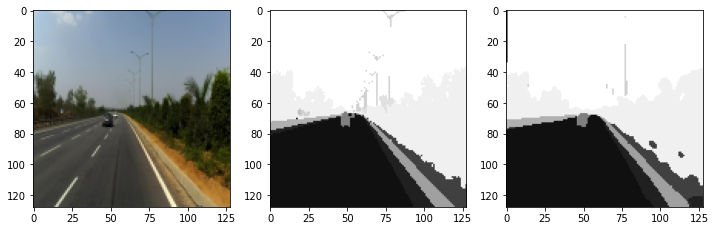

3


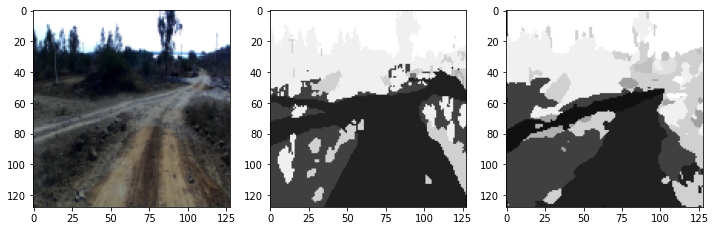

4


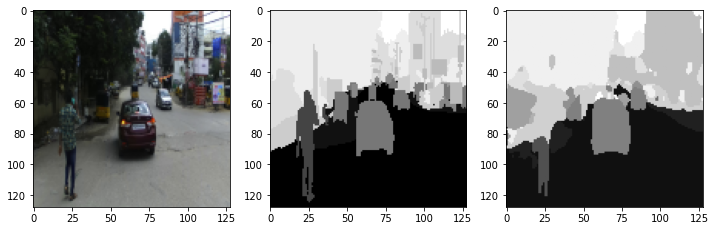

(4, 128, 128, 3)
1


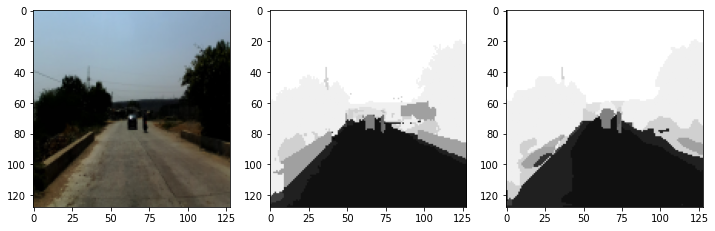

2


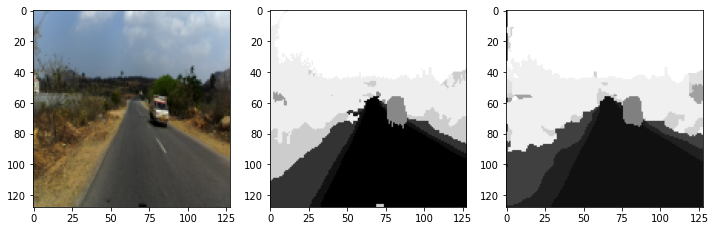

3


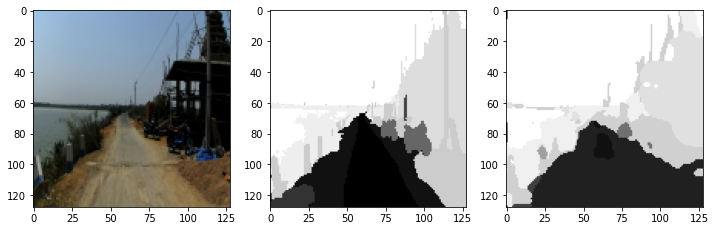

4


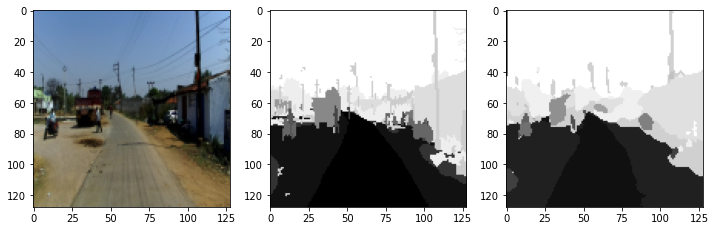

(4, 128, 128, 3)
1


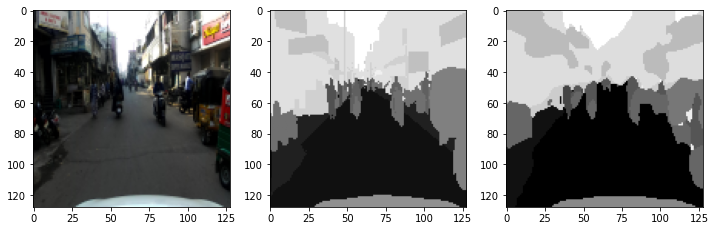

2


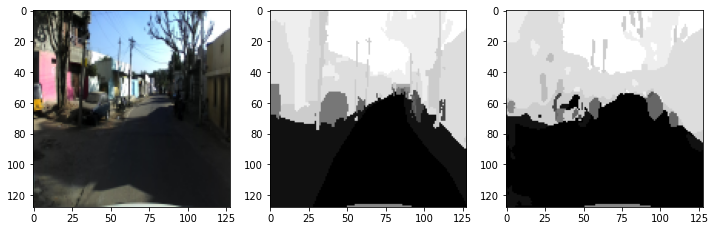

3


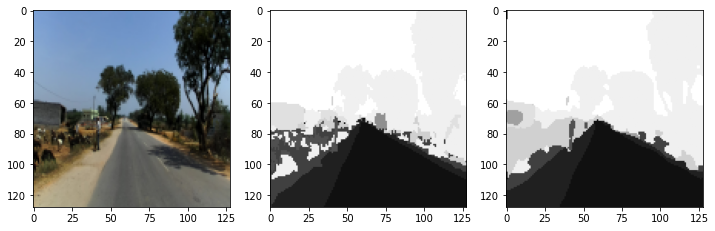

4


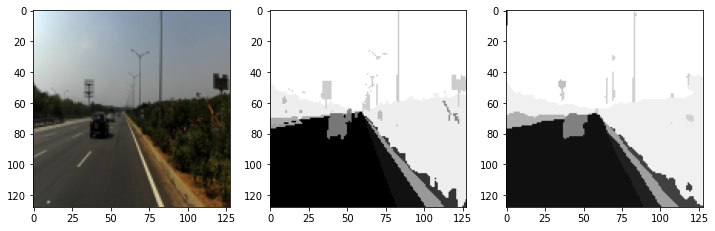

In [ ]:
batch_size = 4
count = 0
for images in test_dataloader:
    count += 1
    x, y = images
    print(x.shape)
    preds = model.predict(x)
    for i in range(batch_size):
        print(i+1)
        actual_image = x[i, :, :, :]
        actual_mask = np.argmax(y, axis=3)[i, :, :]
        predicted_mask = np.argmax(preds, axis=3)[i, :, :]*10
        
        plt.figure(figsize=(12, 6))
        plt.subplot(131)
        plt.imshow(actual_image)
        plt.subplot(132)
        plt.imshow(actual_mask, cmap='gray')
        plt.subplot(133)
        plt.imshow(predicted_mask, cmap='gray')
        plt.show()
    if count > 5:
        break

# Task 3: Training CANet

In [ ]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Multiply,Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

In [ ]:
class convolutional_block(tf.keras.layers.Layer):

    def __init__(self, cnn_type, name="conv_block"):
        super().__init__(name=name)
        
        self.cnn_type = cnn_type

        if  cnn_type == 'C1'  :
            self.std = 2
            self.F1, self.F2, self.F3 = [4, 4, 8]

        elif cnn_type == 'C2' :
            self.std = 2
            self.F1, self.F2, self.F3 = [8, 8, 16]

        elif cnn_type == 'C3' :
            self.std = 1
            self.F1, self.F2, self.F3 =  [16, 16, 32]

        elif cnn_type == 'C4' :
            self.std = 1
            self.F1, self.F2, self.F3 = [ 32, 32, 64]

        # 1st block 
        self.cnn_layer_1 = Conv2D(self.F1, (1,1), name='conv1', strides= 1,        padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.cnn_layer_2 = Conv2D(self.F2, (3,3), name='conv2', strides= self.std, padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.cnn_layer_3 = Conv2D(self.F3, (1,1), name='conv3', strides= 1,        padding="same", kernel_initializer=glorot_uniform(seed=0))
        # skip conncation layer
        self.cnn_layer_4 = Conv2D(self.F3, (3,3), name='conv4', strides= self.std, padding="same", kernel_initializer=glorot_uniform(seed=0))
        
        # 4 layer of the normlization
        self.batch_normalization_1 = BatchNormalization(name='bn_conv1')
        self.batch_normalization_2 = BatchNormalization(name='bn_conv2')
        self.batch_normalization_3 = BatchNormalization(name='bn_conv3')
        self.batch_normalization_4 = BatchNormalization(name='bn_conv4')
        
        # activation function
        self.activation = Activation('relu')
        self.add = Add()

    def call(self, input):
        # write the architecutre that was mentioned above

        # 1st layer of the cnn
        X = self.cnn_layer_1(input)
        X = self.batch_normalization_1(X)
        X = self.activation(X)

        # 2nd layer of the cnn
        X1 = self.cnn_layer_2(X)
        X1 = self.batch_normalization_2(X1)
        X1 = self.activation(X1)

        # 3rd layer of the cnn
        X2 = self.cnn_layer_3(X1)
        X2 = self.batch_normalization_3(X2)

        # skip connecation layer
        X3 = self.cnn_layer_4(input)
        X3 = self.batch_normalization_4(X3)
        X3 = self.activation(X3)

        # element wise addition
        merge = self.add([X2, X3])
        # activation funtion
        merge = self.activation(merge)

        return merge
        

In [ ]:
X_input = Input(shape=(512,512,3))

cnn = convolutional_block(cnn_type= 'C4')
c = cnn(X_input)
c.shape

TensorShape([None, 512, 512, 64])

In [ ]:
X_input = Input(shape=(128,128,8))

# Stage 1
X = Conv2D(4, (1,1), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
print(X.shape)

X1 = Conv2D(4, (3,3), name='conv2',padding="same", kernel_initializer=glorot_uniform(seed=0))(X)
X1 = BatchNormalization(axis=3, name='bn_conv2')(X1)
X1 = Activation('relu')(X1)
print(X1.shape)

X2 = Conv2D(8, (1,1), name='conv3', padding="same", kernel_initializer=glorot_uniform(seed=0))(X1)
X2 = BatchNormalization(axis=3, name='bn_conv3')(X2)
print(X2.shape)

add = tf.add(X2,X_input)
X4 = Activation('relu')(add)
print(X4.shape)

(None, 128, 128, 4)
(None, 128, 128, 4)
(None, 128, 128, 8)
(None, 128, 128, 8)


In [ ]:
class identity_block(tf.keras.layers.Layer):

    def __init__(self, cnn_type, name="identity_block"):
        super().__init__(name=name)
        
        self.cnn_type = cnn_type

        if  cnn_type == 'C1'  :
            self.F1, self.F2, self.F3 = [4, 4, 8]

        elif cnn_type == 'C2' :
            self.F1, self.F2, self.F3 = [8, 8, 16]

        elif cnn_type == 'C3' :
            self.F1, self.F2, self.F3 =  [16, 16, 32]

        elif cnn_type == 'C4' :
            self.F1, self.F2, self.F3 = [32, 32, 64]

        # 1st block 
        self.cnn_layer_1 = Conv2D(self.F1, (1,1), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.cnn_layer_2 = Conv2D(self.F2, (3,3), name='conv2', padding="same", kernel_initializer=glorot_uniform(seed=0))
        self.cnn_layer_3 = Conv2D(self.F3, (1,1), name='conv3', padding="same", kernel_initializer=glorot_uniform(seed=0))
        
        # 4 layer of the normlization
        self.batch_normalization_1 = BatchNormalization(name='bn_conv1')
        self.batch_normalization_2 = BatchNormalization(name='bn_conv2')
        self.batch_normalization_3 = BatchNormalization(name='bn_conv3')
        
        # activation function
        self.activation = Activation('relu')
        self.add = Add()

    def call(self, input):

        # 1st layer of the cnn
        X = self.cnn_layer_1(input)
        X = self.batch_normalization_1(X)
        X = self.activation(X)

        # 2nd layer of the cnn
        X1 = self.cnn_layer_2(X)
        X1 = self.batch_normalization_2(X1)
        X1 = self.activation(X1)

        # 3rd layer of the cnn
        X2 = self.cnn_layer_3(X1)
        X2 = self.batch_normalization_3(X2)

        # element wise addition
        merge = self.add([X2, input])
        # activation funtion
        merge = self.activation(merge)

        return merge
        

In [ ]:
X_input = Input(shape=(128,128,8))

cnn = identity_block(cnn_type= 'C1')
c = cnn(X_input)
c.shape

TensorShape([None, 128, 128, 8])

In [ ]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, filter, name="global_flow"):
        super().__init__(name=name)
        
        self.r, self.c, self.ch = filter

        self.global_avg_pool     = GlobalAveragePooling2D()
        self.batch_normalization = BatchNormalization(name= 'Batch_norm_global_flow') 
        self.activation          = Activation('relu', name= 'relu_activation_lobal_flow')
        self.cnn_1d              = Conv2D(filters= self.ch, kernel_size= 1, name= 'ccn_layer_global_flow')
        self.upsampling          = UpSampling2D(size= (self.r, self.c),interpolation= 'bilinear')
        

    def call(self, X):
        
        X = self.global_avg_pool(X)
        X = self.batch_normalization(X)
        X = self.activation(X)
        X = tf.reshape(X, shape= [-1,1,1, self.ch])
        X = self.cnn_1d(X)
        X = self.upsampling(X)

        return X

In [ ]:
X = Input(shape=(64,64,64))
x = global_flow(filter = (64,64,64))
x(X)

<tf.Tensor 'global_flow/Identity:0' shape=(None, 64, 64, 64) dtype=float32>

In [ ]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, filters, name="context_flow"):
        super().__init__(name=name)

        self.filters = filters

        self.avg_pooling = AveragePooling2D(name = 'avg_pooling')
        self.cnn_1       = Conv2D(self.filters, 3, padding="same", kernel_initializer=glorot_uniform(seed=0), name= 'cnn_1_context_flow')
        self.cnn_2       = Conv2D(self.filters, 3, padding="same", kernel_initializer=glorot_uniform(seed=0), name= 'cnn_2_context_flow')
        self.cnn_3       = Conv2D(self.filters, 1, padding="same", kernel_initializer=glorot_uniform(seed=0), name= 'cnn_3_context_flow')
        self.cnn_4       = Conv2D(self.filters, 1, padding="same", kernel_initializer=glorot_uniform(seed=0), name= 'cnn_4_context_flow')

        self.activation_relu    = Activation('relu')
        self.activation_sigmoid = Activation('sigmoid')
        self.add                = Add()
        self.mul                = Multiply()
        self.upsampling         = UpSampling2D(interpolation= 'bilinear')



    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        concate  = concatenate([INP, FLOW])
        avg_pool = self.avg_pooling(concate)
        cnn      = self.cnn_1(avg_pool)
        cnn      = self.cnn_2(cnn)
                                    
        cnn_3    = self.cnn_3(cnn)
        relu     = self.activation_relu(cnn_3)
        cnn_4    = self.cnn_4(relu)
        sigmoid  = self.activation_sigmoid(cnn_4)

        multi    = self.mul([cnn, sigmoid])
        add      = self.add([cnn, multi])
        X        = self.upsampling(add)   

        return X

In [ ]:
G = Input(shape= (32,32,64))
I = Input(shape= (32,32,64))

x = context_flow(filters = 64)
x([G,I]).shape

TensorShape([None, 32, 32, 64])

In [ ]:
class fsm(tf.keras.layers.Layer):    
    def __init__(self,filters = 32, name="feature_selection"):
        super().__init__(name=name)
        self.f1 = filters
        self.conv1 = Conv2D(filters = self.f1 ,strides = 1, kernel_size= 3,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        self.GMP = GlobalMaxPooling2D()
        self.conv2 = Conv2D(filters = self.f1 ,strides = 1, kernel_size= 3,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        self.bn = BatchNormalization()
        self.activation = Activation('sigmoid')
        self.multi = Multiply()
        self.upsampling = UpSampling2D( interpolation = 'bilinear')
        
    def call(self, X):
        # implement the FSM modules based on image in the above cells
        x1 = self.conv1(X)
        
        x = self.GMP(x1)
        x = tf.reshape(x, shape=[-1, 1,1,self.f1])
        
        x = self.conv2(x)
        x = self.bn(x)
        x = self.activation(x)
        x = self.multi([x1,x])
        
        FSM_Conv_T = self.upsampling(x)
        
        return FSM_Conv_T

In [ ]:
print('Output shape of context flow  :',X.shape)
g = fsm(filters = 32)(X)
print('Ouput shape of FSM            :',g.shape)

Output shape of context flow  : (None, 64, 64, 64)
Ouput shape of FSM            : (None, 128, 128, 32)


In [ ]:
class agcn(tf.keras.layers.Layer):    
    def __init__(self, kernel_size = [(7,1),(1,7),(3,3)],name="global_conv_net"):
        
        super().__init__(name=name)
        self.k1,self.k2,self.k3 = kernel_size
        
        self.conv1 = Conv2D(filters = 32 ,strides = 1, kernel_size = self.k1 ,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        self.conv2 = Conv2D(filters = 32 ,strides = 1, kernel_size = self.k2 ,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        self.conv3 = Conv2D(filters = 32 ,strides = 1, kernel_size = self.k2 ,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        self.conv4 = Conv2D(filters = 32 ,strides = 1, kernel_size = self.k1 ,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        self.conv5 = Conv2D(filters = 32 ,strides = 1, kernel_size = self.k3 ,padding = 'same', kernel_initializer=glorot_uniform(seed=0))
        
        self.add1 = Add()
        self.add2 = Add()  
        
    def call(self, X):
        
        # please implement the above mentioned architecture
        #input is C1
        x = self.conv1(X)
        x1 = self.conv2(x)
        
        x = self.conv3(X)
        x2 = self.conv4(x)
        
        x3 = self.add1([x1,x2])
        x = self.conv5(x3)
        X = self.add2([x3,x])
        
        return X

In [ ]:
X_input = tf.keras.Input(shape=(256,256,3))

X = Conv2D(64, (3, 3), name='conv1', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)

C1 = convolutional_block(cnn_type= 'C1' ,name='conv-block-1')(X)
I1 = identity_block(cnn_type= 'C1',name='Identity_bloack_1_1')(C1)

C2 = convolutional_block(cnn_type= 'C2' ,name='conv-block-2')(I1)
I2 = identity_block(cnn_type= 'C2',name='Identity_bloack_2_1')(C2)
I2 = identity_block(cnn_type= 'C2',name='Identity_bloack_2_2')(I2)
                                                                         
C3 = convolutional_block(cnn_type= 'C3' ,name='conv-block-3')(I2)
I3 = identity_block(cnn_type= 'C3',name='Identity_bloack_3_1')(C3)
I3 = identity_block(cnn_type= 'C3',name='Identity_bloack_3_2')(I3)
I3 = identity_block(cnn_type= 'C3',name='Identity_bloack_3_3')(I3)

C4 = convolutional_block(cnn_type= 'C4' ,name='conv-block-4')(I3)
I4 = identity_block(cnn_type= 'C4',name='Identity_bloack_4_1')(C4)
I4 = identity_block(cnn_type= 'C4',name='Identity_bloack_4_2')(I4)
I4 = identity_block(cnn_type= 'C4',name='Identity_bloack_4_3')(I4)
I4 = identity_block(cnn_type= 'C4',name='Identity_bloack_4_4')(I4)

Global_Flow = global_flow(filter = [32,32,64])(I4)

CF1=context_flow(name="context_flow_1",filters = 64)([I4,Global_Flow])
CF2=context_flow(name="context_flow_2",filters = 64)([I4,CF1])
CF3=context_flow(name="context_flow_3",filters = 64)([I4,CF2])

sum = Add()([Global_Flow,CF1,CF2,CF3])
print(sum.shape)

FSM = fsm(filters = 32)(sum)
print(FSM.shape)
AGCN = agcn(kernel_size = [(7,1),(1,7),(3,3)])(I1)

concat = Concatenate()([AGCN,FSM])

conv =  Conv2D(filters = 21 ,kernel_size = 3,padding = 'same',activation='relu' , 
               kernel_initializer=glorot_uniform(seed=0))(concat)

output = UpSampling2D(interpolation='bilinear',size=(4,4))(conv)

output = Activation('softmax')(output)


(None, 32, 32, 64)
(None, 64, 64, 32)


In [ ]:
# write the complete architecutre

model = Model(inputs = X_input, outputs = output)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 1792        input_10[0][0]                   
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation_59 (Activation)      (None, 256, 256, 64) 0           bn_conv1[0][0]                   
____________________________________________________________________________________________

In [ ]:
x_train, x_test = train_test_split(data_df, test_size = 0.10, random_state = 42)

print(x_train.shape)
print(x_test.shape)
x_train.head()

(3607, 3)
(401, 3)


image  ...                                               mask
1322  /content/data/images/275/frame14890_leftImg8bi...  ...  /content/data/output/275/frame14890_gtFine_pol...
2965  /content/data/images/372/frame1660_leftImg8bit...  ...  /content/data/output/372/frame1660_gtFine_poly...
1450  /content/data/images/277/frame3254_leftImg8bit...  ...  /content/data/output/277/frame3254_gtFine_poly...
3583  /content/data/images/402/frame3912_leftImg8bit...  ...  /content/data/output/402/frame3912_gtFine_poly...
3685  /content/data/images/409/frame1919_leftImg8bit...  ...  /content/data/output/409/frame1919_gtFine_poly...

[5 rows x 3 columns]

In [ ]:
img_size = 256

train_dataset = Dataset(x_train)
test_dataset = Dataset(x_test)

train_dataloader = Dataloder(train_dataset, batch_size = 16, shuffle=True)
test_dataloader = Dataloder(test_dataset, batch_size = 16, shuffle=True)

print(train_dataloader[0][0].shape)
print(train_dataloader[0][1].shape)

(16, 256, 256, 3)
(16, 256, 256, 21)


In [ ]:
from segmentation_models.metrics import iou_score

optim =tf.keras.optimizers.Adam(learning_rate=0.001)
dice_loss=sm.losses.cce_dice_loss
iou_score.threshold= 0.5

model.compile(optim , dice_loss , metrics=[iou_score])

In [ ]:
history_2 = model.fit_generator(train_dataloader , 
                                steps_per_epoch = len(train_dataloader),
                                epochs = 5,
                                validation_data = test_dataloader) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 225 steps, validate for 25 steps
Epoch 1/5
225/225 [==============================] - 271s 1s/step - loss: 0.9067 - iou_score: 0.2982 - val_loss: 0.8820 - val_iou_score: 0.3358
Epoch 2/5
225/225 [==============================] - 266s 1s/step - loss: 0.7976 - iou_score: 0.3891 - val_loss: 0.8646 - val_iou_score: 0.3264
Epoch 3/5
225/225 [==============================] - 265s 1s/step - loss: 0.7586 - iou_score: 0.4169 - val_loss: 0.8464 - val_iou_score: 0.3670
Epoch 4/5
225/225 [==============================] - 265s 1s/step - loss: 0.7352 - iou_score: 0.4341 - val_loss: 0.8005 - val_iou_score: 0.3922
Epoch 5/5
225/225 [==============================] - 265s 1s/step - loss: 0.7160 - iou_score: 0.4483 - val_loss: 0.7653 - val_iou_score: 0.4127


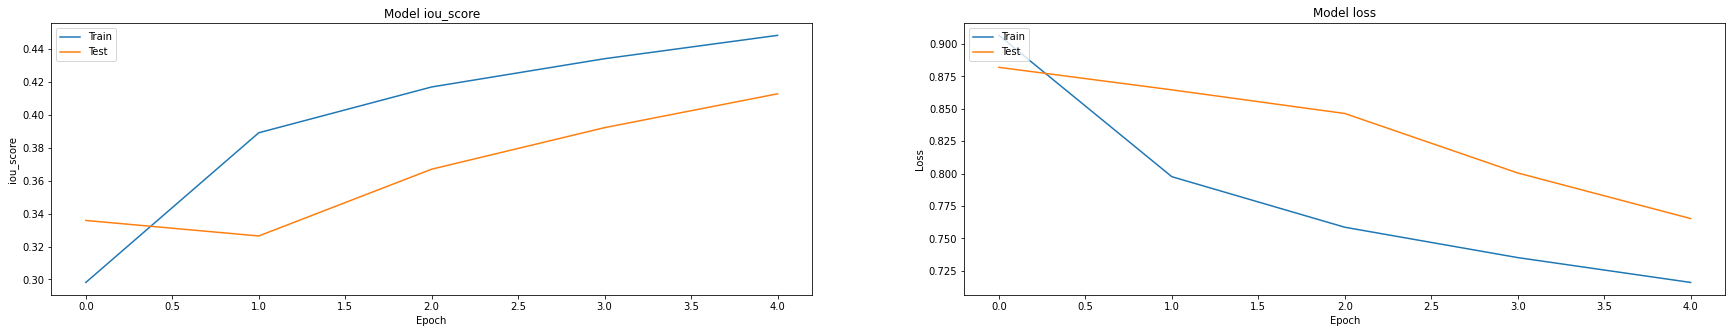

In [ ]:
# Plot training & validation iou_score values
history = history_2 
plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

(16, 256, 256, 3)
0


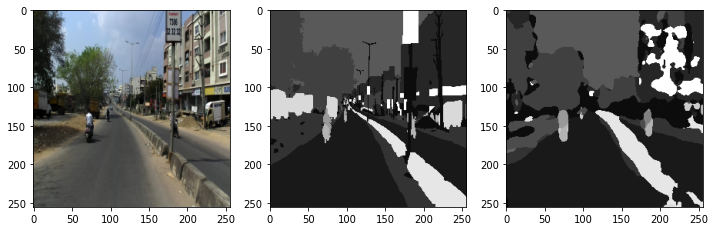

1


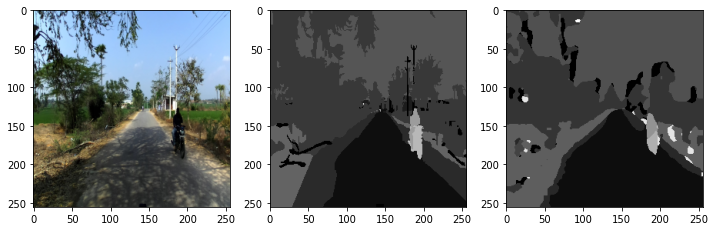

2


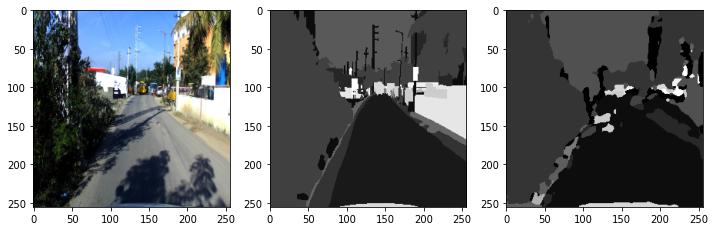

3


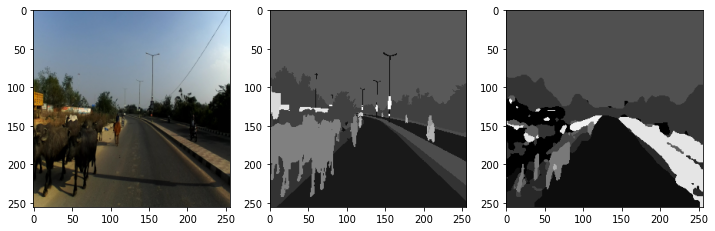

4


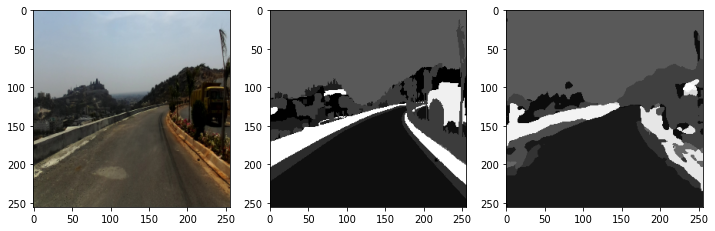

5


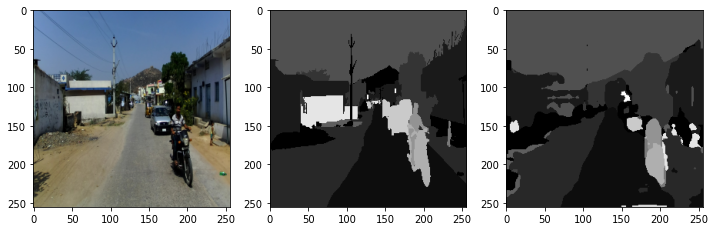

6


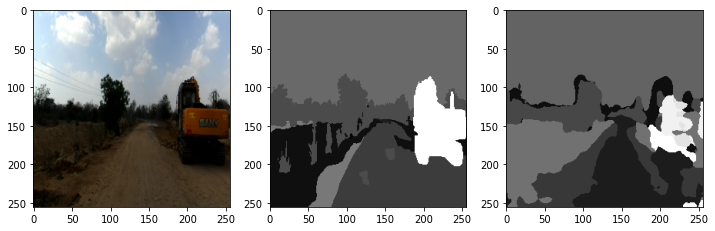

7


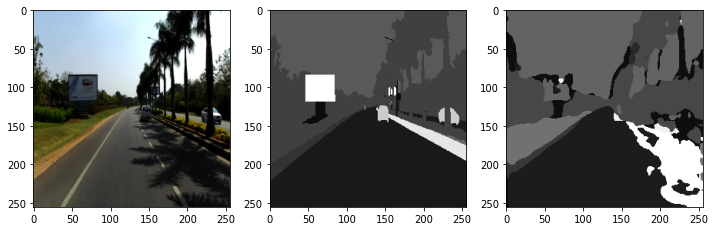

8


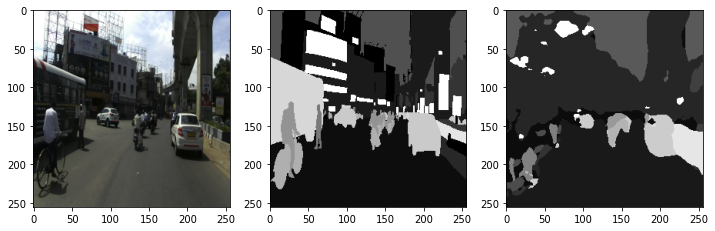

9


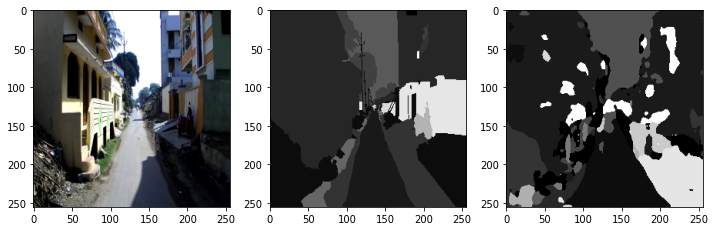

10


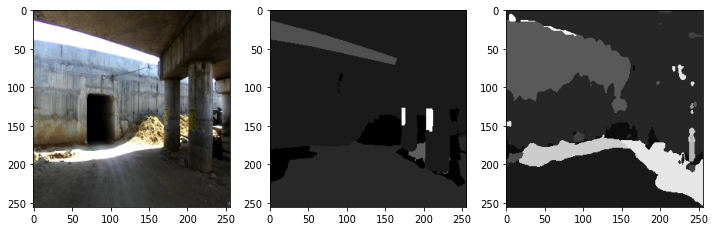

11


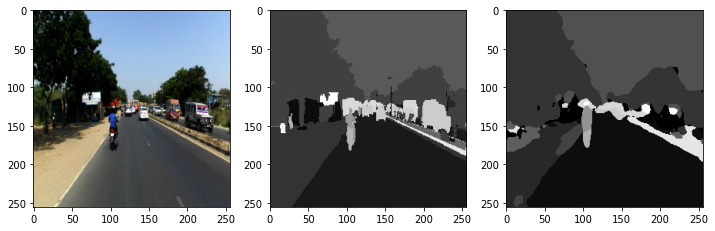

12


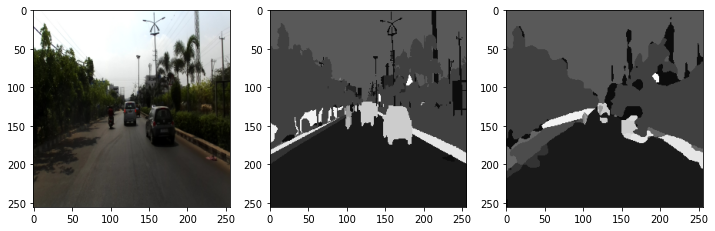

13


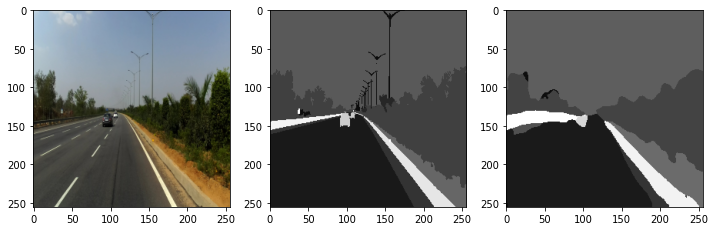

14


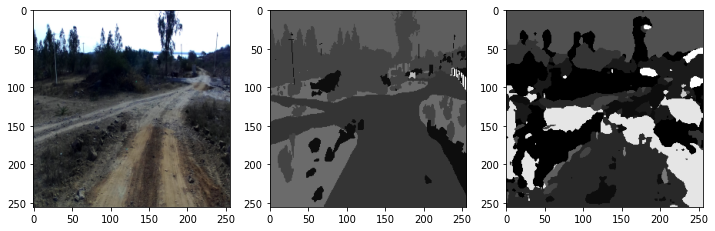

15


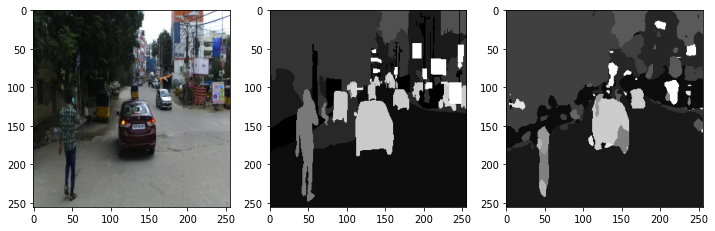

In [ ]:
batch_size = 16
count = batch_size
for images in test_dataloader:
    x, y = images
    print(x.shape)
    preds = model.predict(x)
    for i in range(batch_size):
        print(i+1)
        actual_image = x[i, :, :, :]
        actual_mask = np.argmax(y, axis=3)[i, :, :]
        predicted_mask = np.argmax(preds, axis=3)[i, :, :]*10
        
        plt.figure(figsize=(12, 6))
        plt.subplot(131)
        plt.imshow(actual_image)
        plt.subplot(132)
        plt.imshow(actual_mask, cmap='gray')
        plt.subplot(133)
        plt.imshow(predicted_mask, cmap='gray')
        plt.show()
    break

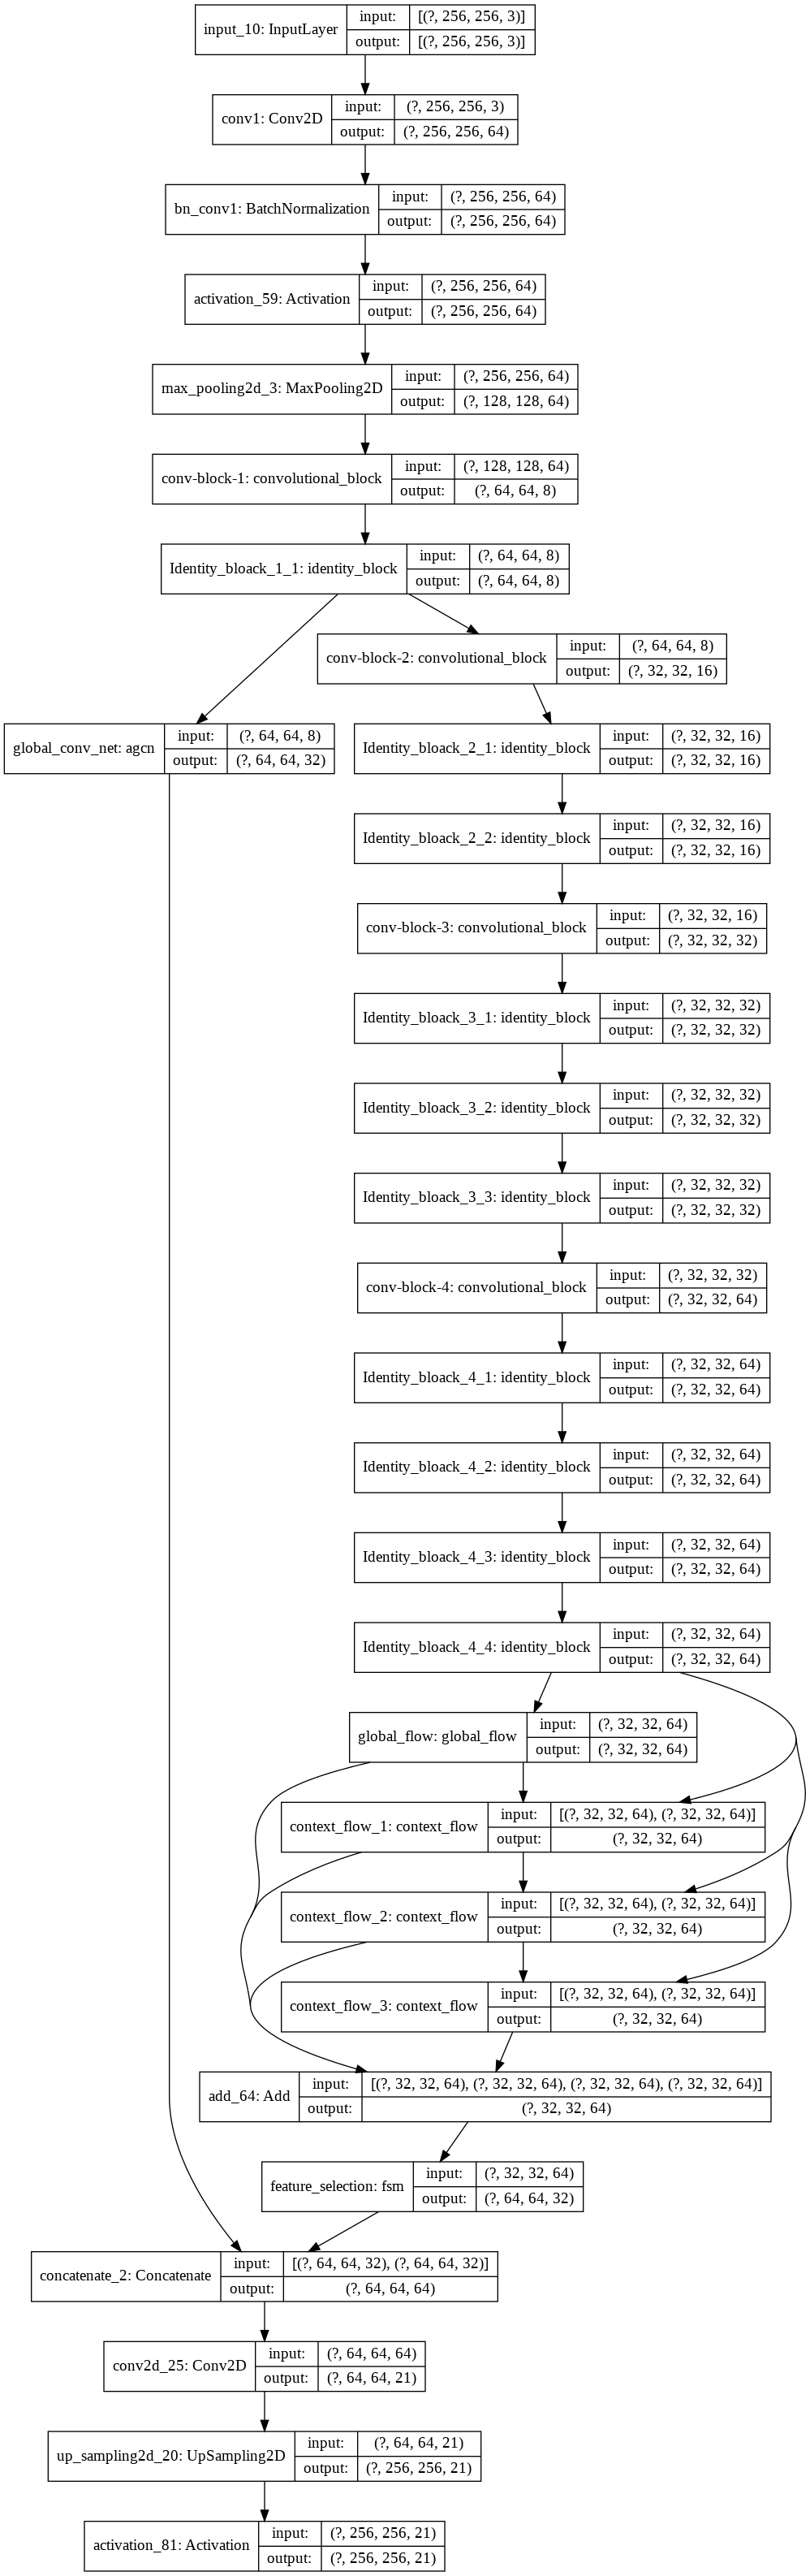

In [ ]:
tf.keras.utils.plot_model(
    model, to_file='model4.png', show_shapes=True, show_layer_names=True,
    rankdir='TB')

# What is the Dice loss ?

https://medium.com/ai-salon/understanding-dice-loss-for-crisp-boundary-detection-bb30c2e5f62b#:~:text=Dice%20loss%20originates%20from%20S%C3%B8rensen,for%203D%20medical%20image%20segmentation.

* Why we need a dice loss, When using cross entropy loss. The more unbalanced the label distributions are, the more difficult the training will be.


* Weighted cross entropy loss can alleviate the difficulty, the improvement is not significant nor the intrinsic issue of cross entropy loss is solved.


* In cross entropy loss, the loss is calculated as the average of per-pixel loss, and the per-pixel loss is calculated discretely, without knowing whether its adjacent pixels are boundaries or not.


* As a result, cross entropy loss only considers loss in a micro sense rather than considering it globally.

* The Dice coefficient tells you how well your model is performing when it comes to detecting boundaries with regards to your ground truth data. The loss is computed with 1 - Dice coefficient where the the dice coefficient is between 0-1.




* In boundary detection tasks, the ground truth boundary pixels and predicted boundary pixels can be viewed as two sets.


* The denominator considers the total number of boundary pixels at global scale, while the numerator considers the overlap between the two sets at local scale.


* When we train our model and reach very low loss value, then we get good prediction in computer vision task like our loss decrease the orignal value of the boundry and prediciton boundry is near or same. 